# CL4 - Recurrent Neural Networks for NLP

This is assignment is done in collaboration with Daniel Langkilde from Recorded Future. For questions, contact him on daniel@recordedfuture.com.

### Named Entity Recognition
The goal of this assignment is to build and train a model for [Named Entity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition). An important part of understanding natural language is being able to accurately locate and classify named entities. Named entities are nouns such as persons, organizations, locations etc. We will treat NER as a sequence labelling problem, and use Recurrent Neural Networks to solve it.

This assignment is broken down into 6 main tasks:
1. Loading the dataset and understanding it
2. Computing the word embeddings
3. Preprocessing the dataset
4. Training a vanilla RNN for this task
5. Training a deep LSTM for this task
6. Evaluating the best model

## 1. Dataset
In this assignment we will a dataset called CoNLL-2002 Shared Task for Named Entity Recognition. It consists of 47 959 sentences, or 1 048 576 words including punctuation, with corresponding entity labels. 

In [1]:
# General Imports
import copy

# Keras imports
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, LSTM, Bidirectional
from keras.layers import Dense, TimeDistributed, Activation, Dropout
from keras import optimizers
from keras import backend as K

# Callbacks for training
from keras.callbacks import EarlyStopping

# Gensim models
from gensim.models import Word2Vec

# Ploting
import matplotlib.pyplot as plt
from matplotlib.pyplot import stem
from sklearn.manifold import TSNE
%matplotlib inline

# Misc imports #
import pandas as pd
import numpy as np
import math 

conll_data = pd.read_csv("./conll_2002_ner_dataset.csv")


Using TensorFlow backend.


### 1.1. Description of dataset

In [2]:
print("Shape of dataset: "+str(conll_data.shape))
conll_data.head(25)

Shape of dataset: (1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


The first column in the dataset is used to indicate when a new sentence begings. 

The second columns holds the word. 

The third column holds the Part-of-Speech tag. The POS tag describes the role of the word in the sentence (like adjective, noun, verb etc). More details are available here https://en.wikipedia.org/wiki/Part_of_speech 

The last column contains the Named Entity Tags. These are the tags we want to be able to predict for a given sentence. The tags in the dataset are

In [3]:
tags = list(conll_data.Tag.unique())
tags.sort(key = lambda x: x[2:]) # sorting them to make it easier to read the list
NUM_CLASSES = len(tags)
print("Number of different tags: "+str(NUM_CLASSES))
tags

Number of different tags: 17


['O',
 'B-art',
 'I-art',
 'B-eve',
 'I-eve',
 'B-geo',
 'I-geo',
 'B-gpe',
 'I-gpe',
 'B-nat',
 'I-nat',
 'B-org',
 'I-org',
 'B-per',
 'I-per',
 'B-tim',
 'I-tim']

As you can see there are 9 different types represented in the dataset. The B- and I- prefixes indicate if the word is the beginning of an entity, or is inside an entity, putting the total number of classes at 17. For example "Barack Obama" would get the labels "B-per I-per". The entities represented are

O&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- No type<br>
Art&nbsp;&nbsp;&nbsp;&nbsp;- Artifact<br>
Eve&nbsp;&nbsp;&nbsp;- Event<br>
Geo &nbsp;- Geographical Entity<br>
Gpe &nbsp;- Geopolitical Entity<br>
Nat &nbsp;&nbsp;- Natural Phenomenon<br>
Org &nbsp;&nbsp;- Organization<br>
Per &nbsp;&nbsp;- Person<br>
Tim &nbsp;&nbsp;- Time Expression<br>

## 2. Computing the word embeddings

The biggest challenge with NLP is that it's sparse. This is sometimes known as the curse of dimensionality. There are many ways to say the same thing, and the meaning of words is highly dependent on context. For computers the representation of words as discrete atoms is blunt. Two words have no inherent notion of similarity in their representation. 


To express this more formally, let's assume we represent words as vectors. The size of our vectors will be the size of our vocabulary. Each word can then be represented as a 1 in a specific position, and zero in all others. There is no meaningful way to compute the similarity between two words in this representation. Instead we've found a way to move from this symbolic representation to a distributed representation that inherently allows for similarity comparisons. 

We base this representation on the assumption that the meaning of a word is implicit in the context in which it appears. Or to paraphrase the famous linguist J.P. Firth ''You shall know a word by the company it keeps''. The idea behind word embeddings is to find a dense vector representation for words such that the cosine distance between two different words is directly proportional to the probability that those two words appear in the same context.

We will now compute such dense vectors, or word embeddings as they are also known, for the words in our dataset. Rather than write everything ourselves we will use a package called gensim. There are some hyperparameters to choose for this, and default values are supplied.

First we want to group the words by which sentence they occur in. We will drop the POS tag for this exercise.
The goal is to get an ndarray with 47958 rows, each with two columns containing the array of words and their labels correspondingly. Fill in your code in the next cell.

In [4]:
def read_conll_data(conll_data):
    """Given a conll_data-CSV, returns a numpy array containing numpy arrays of
       sentences and corresponding tags."""
    
    # List to be returned
    ret_list = []    

    # Create an extract rule to get the row indicies for rows where the column
    # Sentence # is not NaN.
    extract_sentence_idx = conll_data['Sentence #'].notnull()
    
    # Utilize said extract rule to get the row indicies
    sentence_idx_start = list(conll_data[extract_sentence_idx].index)
    
    # Small hack to get all the stop indicies
    sentence_idx_stop = sentence_idx_start[1:] + [len(conll_data)-1]
    
    # Iterate through the indicies list and extract the correct Words and Tags
    for i in range(len(sentence_idx_start)):
        sentence = conll_data['Word'][sentence_idx_start[i] : sentence_idx_stop[i]]
        tags = conll_data['Tag'][sentence_idx_start[i] : sentence_idx_stop[i]]
        
        ret_list.append([np.array(sentence), np.array(tags)])
        
    return np.array(ret_list) 

In [5]:
# Extract the raw data from the conll_data-set
raw_data = read_conll_data(conll_data)

# Check the shape to ensure we get all the sentences
print(raw_data.shape)

# Check that first sentence and tags matches output below
raw_data[0]

(47959, 2)


array([ array(['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through',
       'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and',
       'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from',
       'that', 'country', '.'], dtype=object),
       array(['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O',
       'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'], dtype=object)], dtype=object)




The required output is a numpy.ndarray containing one numpy.ndarray for each sentence. Inside each numpy.ndarray sentence are two numpy.ndarray containing the words and labels respectively. The first numpy.ndarray sentence should look like this:

    array([ array(['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through',
           'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and',
           'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from',
           'that', 'country', '.'], 
          dtype='<U13'),
           array(['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O',
           'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'], 
          dtype='<U5')], dtype=object)

Now we'll use gensim to compute the embeddings. Some hyperparameters are shown here for reference.

In [6]:
# Variables to be used in the Word2Vec generation
VECTOR_SIZE = 100   # Size of each vector in the word embedding
MIN_COUNT = 5       # Cap which ignores words with a frequency lower than MIN_COUNT
MIN_ALPHA = 0.0001  # The minimal learning rate, to which the default learning rate (alpha = 0.025) will linearly drop
WINDOW = 3          # Maximum distance between the current and predicted word within a sentence.

Given our raw dataset your task is to compute a gensim Word2Vec model.

In [7]:
def get_sentences(data):
    """Given an array of arrays, returns the first array in each
       array of ararys."""
    return [list(it[0]) for it in data]
    
def compute_embeddings_model(data):
    """Given a data set, returns a word embedding for said data set."""
    return Word2Vec(data, size=VECTOR_SIZE, min_alpha=MIN_ALPHA, min_count=MIN_COUNT, window=WINDOW)

# Extract sentences and generate word embeddings, also check that their types match the types given below
sentences = get_sentences(raw_data)
print(type(sentences))
embeddings = compute_embeddings_model(sentences)
print(type(embeddings))

<class 'list'>
<class 'gensim.models.word2vec.Word2Vec'>


Here `sentences` is of type `list` and embeddings is of `gensim.models.word2vec.Word2Vec`. If done correctly the following commands:

In [8]:
# Check if the embeddings seem correct (expected result is given below)
embeddings.most_similar('Germany')

[('France', 0.9651553630828857),
 ('Britain', 0.9096989631652832),
 ('Brazil', 0.9069759845733643),
 ('Canada', 0.8774296045303345),
 ('Spain', 0.8558833599090576),
 ('Italy', 0.8527057766914368),
 ('Australia', 0.8340204954147339),
 ('Argentina', 0.8312009572982788),
 ('Japan', 0.8276880979537964),
 ('Russia', 0.799101710319519)]

In [9]:
# Check if the embeddings seem correct (expected result is given below)
embeddings.most_similar(positive=['Paris', 'France'], negative=['Berlin'], topn=10)

[('Germany', 0.759035587310791),
 ('Britain', 0.7312941551208496),
 ('Spain', 0.7275764346122742),
 ('Vietnam', 0.695813775062561),
 ('Japan', 0.6904511451721191),
 ('Italy', 0.666086733341217),
 ('Brazil', 0.6525571346282959),
 ('Australia', 0.6416834592819214),
 ('Thailand', 0.6397740244865417),
 ('Canada', 0.6394137740135193)]

should return something like (expect some variation due to the stochastic nature of t-SNE).

    [('France', 0.9594805240631104),
     ('Britain', 0.8995000123977661),
     ('Brazil', 0.8921124935150146),
     ('Italy', 0.85428786277771),
     ('Spain', 0.8505465984344482),
     ('Canada', 0.8474853038787842),
     ('Japan', 0.8394404053688049),
     ('Argentina', 0.8286175727844238),
     ('Netherlands', 0.8081429600715637),
     ('Russia', 0.8042771220207214)]

and

    [('Germany', 0.7740741968154907),
     ('Britain', 0.708018958568573),
     ('Spain', 0.7058088779449463),
     ('Japan', 0.7046102285385132),
     ('Italy', 0.7018724679946899),
     ('Asia', 0.6579268574714661),
     ('Brazil', 0.6521944403648376),
     ('Canada', 0.6436143517494202),
     ('Vietnam', 0.6399591565132141),
     ('Australia', 0.63737952709198)]

### Visualizing the word Embeddings
Before we move on to the neural networks, let's also plot the embeddings we've computed. To do this we will use a method called t-SNE. t-SNE allows us to find a nice projection of our high dimensional embeddings onto a two dimensional surface. The code is ready to run, no need to add anything to it.

(this might take some minutes to run, depending on your hardware)

In [ ]:
def compute_tsne(embeddings_model):
    embeddings_model.init_sims(replace=True)
    X = embeddings_model[embeddings_model.wv.vocab]
    tsne = TSNE(n_components=2)
    return tsne.fit_transform(X)

tsne = compute_tsne(embeddings)

In [ ]:
# save the resulting projection
plt.rcParams["figure.figsize"] = (100,100)
plt.scatter(tsne[:, 0], tsne[:, 1])
labels = list(embeddings.wv.vocab.keys())
for label, x, y in zip(labels, tsne[:, 0], tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, -1),
        textcoords='offset points', ha='right', va='bottom')

plt.savefig('tsne.pdf')

Why is this visualization helpful? What sort of information does it provide us?

**Your answer**: We find that words thet relate to oneanother are spatially close in the figure. For instance we see Bush, Obama, Clinton, Castro, and other names related to leaders in a cluster, in the figure! We also find a cluster with countries.

This helps us understand how the wordembedding relates words of different kinds.

## 3. Preprocessing

We will need to do some more preprocessing of our data for it to be useful to train an RNN. The following code defines some helpful variables for you.

In [10]:
# Create variables to be used when deciding the dimensionality of the data
NUM_SENTENCES = len(sentences)
MAX_SENT_LENGTH = 0

for sentence in sentences:
    length = len(sentence)
    if length > MAX_SENT_LENGTH: 
        MAX_SENT_LENGTH = length
        
print("Number of sentences: "+str(NUM_SENTENCES))
print("Maximum sentence length: "+str(MAX_SENT_LENGTH))
print("Number of target classes: "+str(NUM_CLASSES))

Number of sentences: 47959
Maximum sentence length: 104
Number of target classes: 17


There are 5 things we need to do before we are ready to train our Recurrent Neural Network. We will need to

1. <b>Replace words with their embeddings</b><br>
We've previously computed word embeddings, and we now need to transform our sequences of tokens into sequences of word vectors.
<br>
2. <b>One-hot encode targets</b><br>
Each token can have any of our 17 classes. We want to represent the class of a token with a one-hot encoded vector.
<br>
3. <b>Zero-pad sentences and targets</b><br>
We need all our sequences to be of equal length in order for the matrix algebra to work out. To achieve this we will zero pad each sentence with zero vectors, and each target with zero tags.
<br>
4. <b>Check dimensions of our data</b><br>
It's a good practice to always check the dimensionality of your dataset before you start training your model.
5. <b>Split into train and test set</b><br>
Finally we want to split our dataset into a train and test set.

### 3.1 Replace words with their embeddings
We will now replace each word in our list of sentences with their word vector. If a word is not in our vocabulary we will sample its vector representation from a normal distribution instead (common practice for these problems).

In [11]:
def get_vector_for_unknown_word(dim):
    """Returns a vector containing dim random numbers"""
    unk_vec = 2*np.random.randn(dim)-1
    norm_const = np.linalg.norm(unk_vec)
    unk_vec /= norm_const
    return unk_vec

def replace_words_with_embeddings(sentences, embeddings):
    """Given a list of sentences and a word embedding, returns a
       list where the sentences are replaced by corresponding word embeddings
       
       If a word is not present in the word embedding, we utilize
       get_vector_for_unknown_word(VECTOR_SIZE) to get a random vector for said word."""
    
    # List to be returned
    wv_list = []
    
    # Iterate through all sentences
    for sentence in sentences:
        
        # Iterate through each word in each sentence
        tmp_list = []
        
        for word in sentence:
        
            # Try to add the corresponding word embedding,
            # if the lookup fails we resort to randomizing a vector.
            try:
                tmp_list.append(embeddings.wv[word])
            except:
                tmp_list.append(get_vector_for_unknown_word(VECTOR_SIZE))
        
        wv_list.append(tmp_list)
    
    return wv_list

We will use the list of sentences and our computed embeddings as input.

In [12]:
# Replace the words in the sentences with embeddings
data = replace_words_with_embeddings(sentences, embeddings)

# Check that the type of the data is consistent with the type given below
print(type(data))
print(type(data[0]))
print(type(data[0][0]))

<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>


Our output here should be of type List where each List entry is a List of word vectors. Word vectors will be of type `numpy.ndarray`.

### 3.2 One-hot encode targets
Similar to the previous steps we will now replace our sequence of entity tags with vectors. Each entity tag will be one-hot encoded, which means that it will be represented by a vector with dimension equal to the number of classes. The entity type of a specific token will be represented by a 1, with all other classes 0.

In [13]:
def get_targets(data):
    """Return all tags"""
    return list(map(lambda pair: pair[1], data))


def one_hot_encode_targets(targets, list_of_tags):
    """Given a list of lists of tags (corresponding to tagged sentences),
       returns one hot encoded lists of lists"""
    
    # List to be returned
    one_hot_list = []
    
    # Iterate through all "tag sentences"
    for tags in targets:
        
        tmp_sentence = []
        
        # For each tag in each sentence we swap the tag for a one hot vector
        for tag in tags:
            tmp_words = [0]*NUM_CLASSES
            idx = list_of_tags.index(tag)
            tmp_words[idx] = 1
            tmp_sentence.append(np.array(tmp_words))
        
        one_hot_list.append(np.array(tmp_sentence))
    
    return one_hot_list

In [14]:
# Extract the targets from the raw data
raw_targets = get_targets(raw_data)

# Convert targets to one hot encoding
targets = one_hot_encode_targets(raw_targets, tags)

# Print the first target to compare with the output given below
targets[0]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Similar to the sentence case, raw_targets here will be of type List. Each entry in this list will be a numpy.ndarray of labels.

targets will be of type List with each sentence represented by a numpy.ndarray of numpy.ndarrays holding 1s and 0s. The first sentence should look like this:

### 3.3 Zero-pad sentences and targets
We need all our sequences to be of equal length in order for the matrix algebra to work out. To achieve this we will zero-pad each sentence with zero vectors.

In [15]:
def zero_pad_sentence(sentence, max_length):
    """Given a numpy array and a max length,
       pads said array with zeros until it is max_length long"""
    
    # Check how much we need to pad the array
    padding_length = max_length - len(sentence)
    
    # Create a zero-array of correct length
    padding_array = np.zeros((padding_length, VECTOR_SIZE))
    
    # Return a concatonated array, consisting of the original
    # sentence vector and the zero-array
    return np.concatenate((sentence, padding_array))

In [ ]:
# List to hold the padded sentences
padded_data = []

# For each sentence in the data set we call the padding function 
# and append the output to the list
for sentence in data:
    padded_data.append(np.array(zero_pad_sentence(sentence, MAX_SENT_LENGTH)))

# Convert the aforementioned list to a numpy array and check its shape
data = np.array(padded_data)

# Save the array to save time during testing
# np.save("zero-padded-sentences.npy", data)

print("Dimensionality check should be True -> {}".format(data.shape == (NUM_SENTENCES, MAX_SENT_LENGTH, VECTOR_SIZE)))

Once we're finished with our preprocessing we transform our list of data points to a numpy.ndarray. That means we should now have data of type numpy.ndarray, where each sentence is represented by a numpy.ndarray of word vectors in the form of numpy.ndarrays. The shape should be `(47958, 104, 100)`.

Next we will zero-pad our targets with the "no entity" type label.

In [16]:
def zero_pad_target(target, max_length):
    """Given a vector and a max length, returns a padded vector
       corresponding to a 'No type' one hot encoding"""

    # Check how much we need to pad
    padding_length = max_length - len(target)
    
    # Create a one hot encoded vector corresponding to 'No type'
    one_hot_vector = np.concatenate(([1],[0]*(NUM_CLASSES-1)))
    
    # Duplicate the one hot vector padding_length times 
    padding_array = np.tile(one_hot_vector, (padding_length, 1))
    
    # Return a concatenated vector, consisting of the input and the
    # padding vector
    return np.concatenate((target, padding_array))

In [ ]:
# Array to hold the tags
padded_data = []

# For each target, invoke the padding function and append the output to the return list
for target in targets:
    padded_data.append(np.array(zero_pad_target(target, MAX_SENT_LENGTH)))

# Convert the output to an numpy array and check its shape
targets = np.array(padded_data)

# Save the array to save time during testing
# np.save("zero-padded-targets.npy", targets)
print("Dimensionality check should be True -> {}".format(targets.shape == (NUM_SENTENCES, MAX_SENT_LENGTH, NUM_CLASSES)))

Similar to our data our targets should now be a numpy.ndarray of numpy.ndarray of numpy.ndarray. The shape should be `(47958, 104, 17)`.

### 3.4 Check data dimensions
To ensure that we've succeeded in preprocessing all our data appropriately we will check some dimensionality.

In [17]:
# During testing, the arrays were written to disk
data = np.load("zero-padded-sentences.npy")
targets = np.load("zero-padded-targets.npy")

# Ensure our dimensionality seems okay!
NUM_SENT_OK = targets.shape[0] == data.shape[0]
TARGET_LENGHT_OK = MAX_SENT_LENGTH == targets.shape[1]
DATA_LENGTH_OK = MAX_SENT_LENGTH == data.shape[1]
VECTOR_SIZE_OK = data.shape[2] == VECTOR_SIZE
print("Target lenght ok: "+str(TARGET_LENGHT_OK))
print("Data lenght ok: "+str(DATA_LENGTH_OK))
print("Vector size ok: "+str(VECTOR_SIZE_OK))
print("Num sent ok: "+str(NUM_SENT_OK))

Target lenght ok: True
Data lenght ok: True
Vector size ok: True
Num sent ok: True


The booleans should all be True to proceed.

### 3.5 Split into train and test data
We will split our dataset into a train and a test part. We will use 20% of the data to test.

In [18]:
# Split the data set into training and testing sets
TEST_FRACTION = 0.2
NUM_TEST = math.ceil(NUM_SENTENCES * TEST_FRACTION)
NUM_TRAIN = NUM_SENTENCES - NUM_TEST
x_train = data[:NUM_TRAIN]
y_train = targets[:NUM_TRAIN]
x_test = data[NUM_TRAIN+1:]
y_test = targets[NUM_TRAIN+1:]

In [19]:
# Check the shapes of said sets
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(38367, 104, 100)
(38367, 104, 17)
(9591, 104, 100)
(9591, 104, 17)


## 4. Training a simple RNN
We are finally ready to train our first Recurrent Neural Network. 

### 4.1 Training

Design a single-layer vanilla RNN to predict the class of each word in the sentences.

Hints:
- Keras has a layer called `SimpleRNN`, for implementing this type of RNNs.
- Maybe you want to take a look at the `TimeDistributed` layer too. 

In [20]:
# The precision, recall and f-score metrics were removed in Keras 2.0, this is the code from Keras 1.2.0
# (https://github.com/fchollet/keras/blob/53e541f7bf55de036f4f5641bd2947b96dd8c4c3/keras/metrics.py)
def precision(y_true, y_pred):
    """Compute Precision metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())    
    return precision

def recall(y_true, y_pred):
    """Recall metric."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score."""
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

###########################################################################################################

def vanillaModel(HIDDEN_UNITS=50):
    """Create a vanilla RNN model constituting of a SimpleRNN and a TimeDistributed layer"""
    
    # Initialization of the sequential model
    model = Sequential()
    
    # Add a SimpleRNN layer
    # return_sequences is set to True, this means that we will return the entire last sequence and not only the last output
    # The input_shape is that of each sentence
    model.add(SimpleRNN(units=HIDDEN_UNITS, activation='relu', return_sequences=True, input_shape=(MAX_SENT_LENGTH, VECTOR_SIZE)))
    
    # Add a TimeDistributed + Dense layer, where each Dense layer ends with a softmax.
    model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
    
    # Compile the model and make use of the fbeta_score function above as metrics function
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[fbeta_score]) 
    
    return model

Compile and train it. Motivate your choice of loss and metrics for this particular problem.

Train on 30693 samples, validate on 7674 samples
Epoch 1/50
30693/30693 [==============================] - 27s - loss: 1.6009 - fbeta_score: 0.4671 - val_loss: 0.3757 - val_fbeta_score: 0.9669
Epoch 2/50
30693/30693 [==============================] - 27s - loss: 0.2457 - fbeta_score: 0.9654 - val_loss: 0.1455 - val_fbeta_score: 0.9694
Epoch 3/50
30693/30693 [==============================] - 26s - loss: 0.1252 - fbeta_score: 0.9717 - val_loss: 0.1115 - val_fbeta_score: 0.9741
Epoch 4/50
30693/30693 [==============================] - 27s - loss: 0.1012 - fbeta_score: 0.9762 - val_loss: 0.0932 - val_fbeta_score: 0.9776
Epoch 5/50
30693/30693 [==============================] - 27s - loss: 0.0873 - fbeta_score: 0.9788 - val_loss: 0.0825 - val_fbeta_score: 0.9795
Epoch 6/50
30693/30693 [==============================] - 26s - loss: 0.0786 - fbeta_score: 0.9805 - val_loss: 0.0755 - val_fbeta_score: 0.9808
Epoch 7/50
30693/30693 [==============================] - 28s - loss: 0.0727 - fbeta_sc

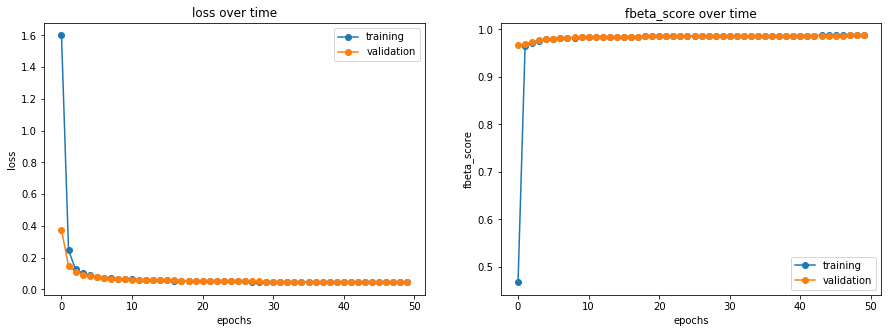

In [23]:
# Create a model
rnn_model = vanillaModel()

# We did not ever really see any tendencies of overfitting,
# hence we set the #epoch to a reasonable number (50),
# since the val_fbeta_score seemed to change only marginally after that
# and time was of the essence

# Train said model
history = rnn_model.fit(x_train, y_train,
          batch_size=512,
          epochs=50,
          validation_split=.2)

# Plot the loss against the precision for the training and validation data
fig, axes = plt.subplots(1,2, figsize=[15, 5])

axes[0].plot(history.history['loss'], '-o')
axes[0].plot(history.history['val_loss'], '-o')

axes[1].plot(history.history['fbeta_score'], '-o')
axes[1].plot(history.history['val_fbeta_score'], '-o')

axes[0].set_xlabel('epochs')
axes[1].set_xlabel('epochs')

axes[0].set_ylabel('loss')
axes[1].set_ylabel('fbeta_score')

axes[0].set_title('loss over time')
axes[1].set_title('fbeta_score over time')

axes[0].legend(['training', 'validation'])
axes[1].legend(['training', 'validation']);

**Motivations**: We have chosen Categorical Crossentropy as our loss function and F Score (fbeta_score) as our metrics function. Both due to the nature of our data set:

Loss: We want to categorize each word as one of many classes. It would be even more interesting to make use of a weighted categorical crossentropy loss function (one that more heavily penalizes classifying non No-Type words as No-Type. As for now, if the model wants to, it could totally ignore some tags if it finds this beneficial. We did however not have time to implement this.

Metrics: The F Score is the weighted harmonic mean of precision and recall. If we were to only look at the precision of a model, we could be fooled to believe the model is good due to the biased data. In order to avoid this, we use the recall to penalize incorrect assignments as well!

### 4.2 Testing new sentences
Now that we have a model, let's check how it performs on some sentences. Create a function that takes as input a string, which will be the sentence we want to perform NER, and a Keras model for doing it. The output should be the predicted probabilities for each label, for each of the words in the provided sentence. More specifically, it should be a `numpy.ndarray` with shape (`num_words`, `num_classes`), where `num_words` is the number of words in the input sentence and `num_classes` is the number of classes we can predict.

In [24]:
def perform_ner(sentence, model):
    """Given a sentence and a model, predicts the Name Entitiy Recognition
       for the sentence using the model"""
    
    # Split the sentence into words
    split_sent = sentence.split(" ")
    
    # Use the word embedding from earlier to swap out the words for vectors
    embedding = replace_words_with_embeddings([split_sent], embeddings)
    
    # Pad the embedding-sentence
    embedding_pad = zero_pad_sentence(embedding[0], MAX_SENT_LENGTH).reshape(1, MAX_SENT_LENGTH, VECTOR_SIZE)
    
    # Make the actual prediction
    prediction = model.predict(embedding_pad, batch_size=1)
    
    return prediction

Test it on the following sentence:

In [25]:
# Use a dummy sentence and use the perform_ner()-function to tag the sentence
sentence1 = "The constitution states that thou shalt not kill ."
prediction = perform_ner(sentence1, rnn_model)

To make it easier to visualize the prediction probability mass function for each word, create a function that receives your prediction, and plots the pmf for each word separately. 

Requirements:
- All plots should have titles showing the word associated to that pmf.
- The labels for the x-axis should be the name of the tags, aligned vertically (i.e. `rotation='vertical'` when calling the `xticklabels` method.

In [26]:
def plot_prediction(sentence, prediction):
    """Given a sentence and a list containing the ner-predictions for said sentence,
       plot the pmf for each word in the sentence"""
    
    # Split the sentence into words
    split_sen = sentence.split(" ")
    
    # Create a figure that consists of "number of words" sub figures
    fig, ax = plt.subplots(len(split_sen), 1, figsize=[5,len(split_sen)*2])
    
    # For each word in the sentence, plot the pmf for that word
    for idx, word in enumerate(split_sen):
        ax[idx].stem(prediction[0][idx])
        ax[idx].set_xticks(np.arange(len(tags)))
        ax[idx].set_xticklabels(tags, rotation='vertical',)
        ax[idx].set_title("Word: {}".format(word))
        ax[idx].set_ylim(0,1)
    
    plt.tight_layout()
    return


def plot_compare_predictions(sentence, prediction1, prediction2, tags):
    """Given a sentence and two lists containing the ner-predictions for said sentence,
       plot the pmf for each word in the sentence in a way that let you compare the
       two predictions"""
    
    # Split the sentence into words
    split_sen = sentence.split(" ")
        
    # Create a figure that consists of "number of words"x2 sub figures
    fig, ax = plt.subplots(len(split_sen), 2, figsize=[10,len(split_sen)*2])
    
    # For each word in the sentence, plot the pmf for each prediction, for that word
    for idx, word in enumerate(split_sen):
        ax[idx][0].stem(prediction1[0][idx])
        ax[idx][1].stem(prediction2[0][idx])
        ax[idx][0].set_xticks(np.arange(len(tags)))
        ax[idx][1].set_xticks(np.arange(len(tags)))
        ax[idx][0].set_xticklabels(tags, rotation='vertical',)
        ax[idx][1].set_xticklabels(tags, rotation='vertical',)
        ax[idx][0].set_title("Word: {}".format(word))
        ax[idx][1].set_title("Word: {}".format(word))
        #ax[idx][0].set_ylim(0,1)
        #ax[idx][1].set_ylim(0,1)
    
    plt.tight_layout()
    return

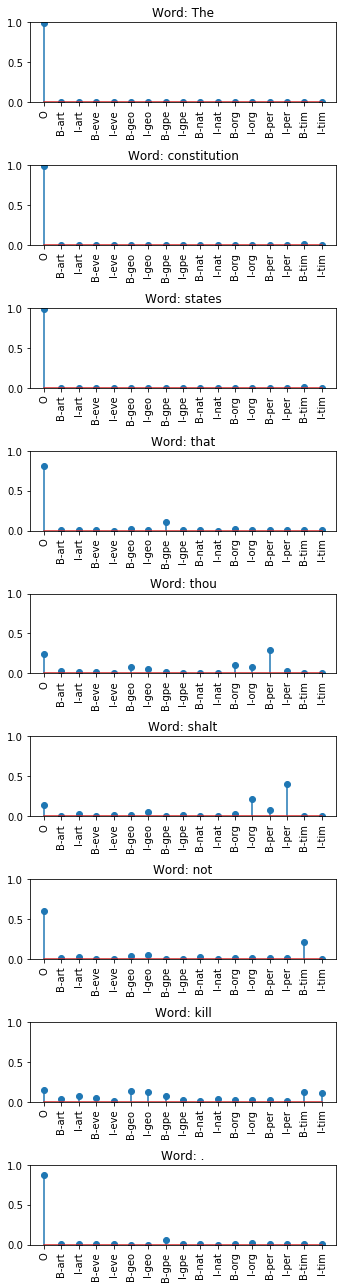

In [27]:
plot_prediction(sentence1, prediction)

Finally, write a function that takes your pmf predictions and converts it to hard predictions (i.e. returns a list with the most probable label for each word).

In [28]:
def decode_prediction(prediction):
    """Given an array of predictions, returns an array with which
       ever tag each prediction deemed most likely"""
    
    # List to be returned
    pred_tags = [] 
    
    # For each prediction, get the tag corresponding to the maximum prediction
    for p in prediction[0]:
        pred_tags.append(tags[p.argmax()])
        print("Tag: {}".format(tags[p.argmax()]))
        
    return pred_tags


def decode_compare_prediction(prediction1, prediction2):
    """Given two predictions, checks whether the two predictions prediced
       the same thing (for each word)."""
    
    # For each prediction check the tag for both models and print the tag
    # and whether or not the models predicted the same thing
    for p1, p2 in zip(prediction1[0], prediction2[0]):
        t1 = tags[p1.argmax()]
        t2 = tags[p2.argmax()]
        same = t1 == t2
        print("RNN: {} | LSTM: {} | SAME: {}".format(t1, t2, same))
        
    return 

In [29]:
# Get the "hard predictions" for a particular prediction, and print said predictions
prediction_list = decode_prediction(prediction)

Tag: O
Tag: O
Tag: O
Tag: O
Tag: B-per
Tag: I-per
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O


Now we perform the same steps again, but for another sentence:

Tag: O
Tag: O
Tag: I-org
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O
Tag: O


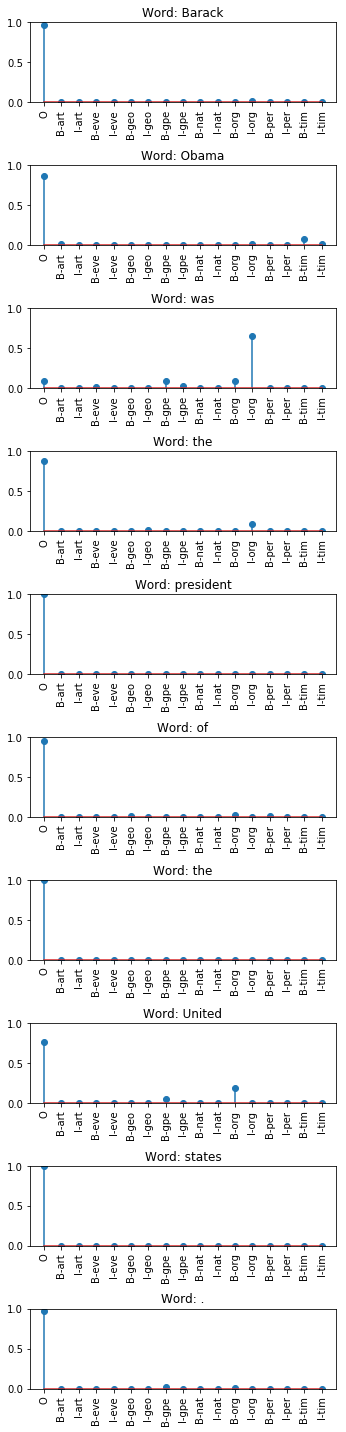

In [30]:
# Use another dummy sentence and NER it
sentence2 = "Barack Obama was the president of the United states ."
prediction2 = perform_ner(sentence2, rnn_model)

# Plot the prediction and print the hard predictions
plot_prediction(sentence2, prediction2)
prediction_list2 = decode_prediction(prediction2)

What can you observe from the output from these two sentences? 

**Your answer**: Firstly we see what we have already concluded: the data set has many more 'Non type' tags than any other tag.

We see that even though we get decent f-score in our training, the first sentence yields very few tags that are not No-type. We also find that retraining the model will yield slightly different results and sometimes the model is able to classify +/- one word.

Looking at the second sentence, we have (according to us) two PER (Barack, Obama) one GPE (president) and two GEO/GPE (United States). Again, we see that No-Type dominates and again we see (not in the file, but as we have worked with our model) that the neuances are so fine that the slightest difference in training the model results in widely different results. A previous iteration of the model was able to correctly classify 3 out of the aforementioned 5 non No-Type tags, above the result is 0 out of 5.

How was the word "states" classified in each sentence? Why do you think this happened?

**Your answer**: In this particular case, both instances of "states" were classified as No-Type.

## 5. Deep LSTM RNN
As we stated before, distant dependencies between words are difficult to capture with vanilla RNNs. This is referred to as the vanishing/exploding gradient problem.

Several different architectures for RNNs have been proposed to deal with the vanishing/exploding gradient problem. One of the most successful in recent years has been Long-Short Term Memory networks (LSTM). LSTM are capable of learning long-term dependencies. They were introduced in 1997, but have been popularized through the general increase in interest for deep learning. The difference between an LSTM and an RNN is the structure of the repeating module. The core idea is that LSTM have the ability to remove or add information to the cell state using structures called gates.

We can further improve our model by introducing Long-Short Term Memory cells and adding multiple layers. Design a new model using LSTMs. This time, you're free to add more layers, and/or use other layer wrappers (like the `Bidirectional`, for instance).

In [31]:
def simple_lstm(HIDDEN_UNITS=128):
    """Create a small bidirectional LSTM model"""

    # Start of the model
    model = Sequential()
    
    # Add a bidirectional lstm layer
    model.add(Bidirectional(LSTM(units=HIDDEN_UNITS, return_sequences=True), input_shape=(MAX_SENT_LENGTH, VECTOR_SIZE)))
    
    # Utilize dropout to set 25% of the weights to zero
    model.add(Dropout(0.25))
    
    # Add a dense layer of size "number of tags" = 17
    model.add(Dense(len(tags)))
    
    # Use softmax to get predictions
    model.add(Activation('softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[fbeta_score])

    return model

Compile and train your model. As before, motivate your choice of loss and metrics for this problem.

In [33]:
# Create the model
lstm_model = simple_lstm()

# Again, as was mentioned before, we did see no tendencies
# of overfitting in our training, we opted for a lower number
# of epochs due to time restrictions

# Train the model
lstm_history = lstm_model.fit(x_train, y_train,
                              batch_size=512,
                              epochs=10,
                              validation_split=.2)


Train on 30693 samples, validate on 7674 samples
Epoch 1/10
30693/30693 [==============================] - 523s - loss: 0.5834 - fbeta_score: 0.8155 - val_loss: 0.1423 - val_fbeta_score: 0.9686
Epoch 2/10
30693/30693 [==============================] - 413s - loss: 0.1172 - fbeta_score: 0.9726 - val_loss: 0.0943 - val_fbeta_score: 0.9765
Epoch 3/10
30693/30693 [==============================] - 359s - loss: 0.0853 - fbeta_score: 0.9786 - val_loss: 0.0726 - val_fbeta_score: 0.9812
Epoch 4/10
30693/30693 [==============================] - 366s - loss: 0.0699 - fbeta_score: 0.9820 - val_loss: 0.0625 - val_fbeta_score: 0.9835
Epoch 5/10
30693/30693 [==============================] - 357s - loss: 0.0625 - fbeta_score: 0.9836 - val_loss: 0.0572 - val_fbeta_score: 0.9846
Epoch 6/10
30693/30693 [==============================] - 420s - loss: 0.0579 - fbeta_score: 0.9846 - val_loss: 0.0537 - val_fbeta_score: 0.9854
Epoch 7/10
30693/30693 [==============================] - 451s - loss: 0.0548 - f

**Motivations**: The motivation for loss and metrics is the same as given for the vanilla RNN above.

Test it on the same sentences as before.

RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | L

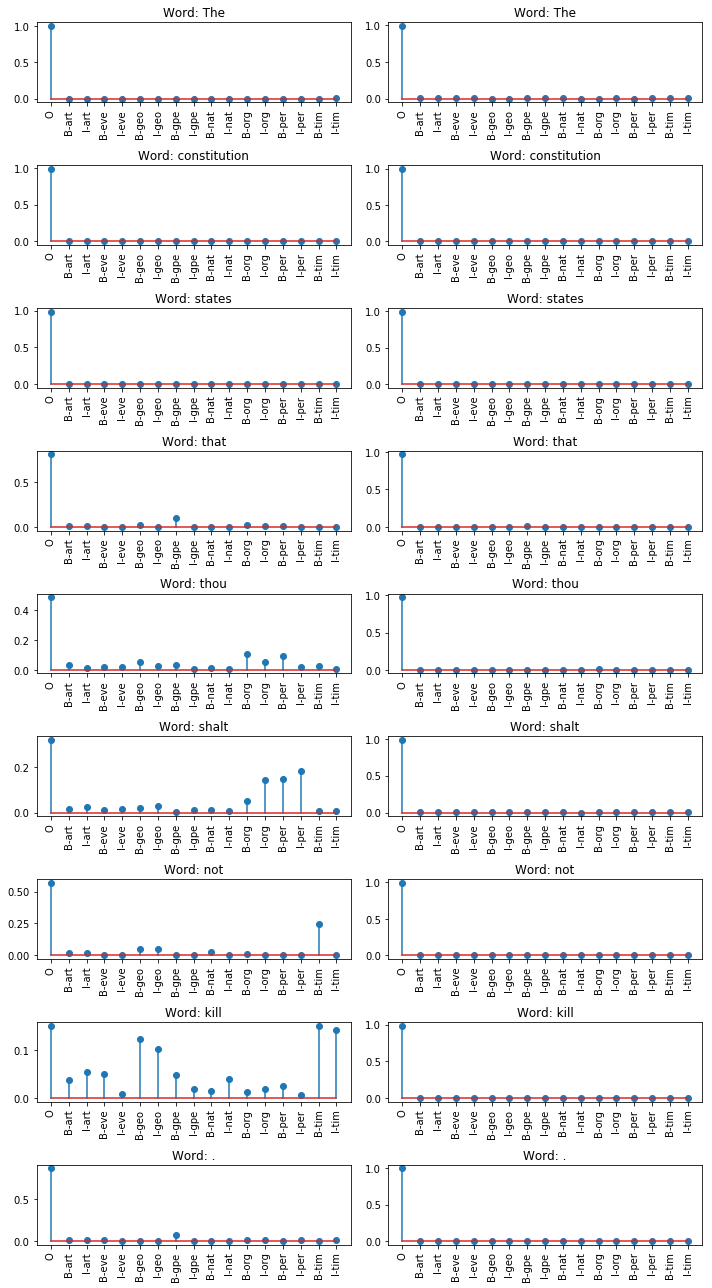

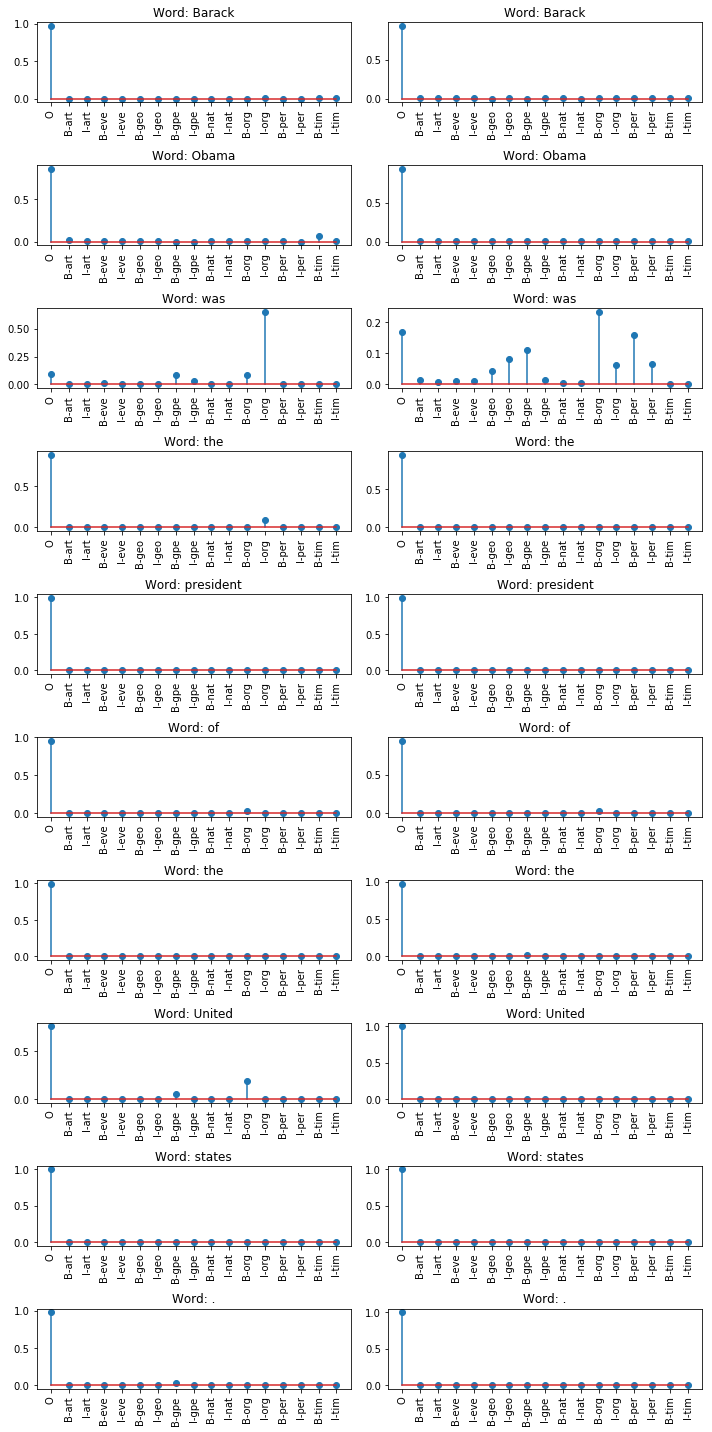

In [34]:
## SENTENCE 1
# Predict the same sentence using both models
lstm_prediction1 = perform_ner(sentence1, lstm_model)
rnn_prediction1 = perform_ner(sentence1, rnn_model)

# Decode and compare the two predictions
decode_compare_prediction(rnn_prediction1, lstm_prediction1)

# Plot and compare the two predictions
plot_compare_predictions(sentence1, rnn_prediction1, lstm_prediction1, tags)

## SENTENCE 2
# Predict the same sentence using both models
lstm_prediction2 = perform_ner(sentence2, lstm_model)
rnn_prediction2 = perform_ner(sentence2, rnn_model)

# Decode and compare the two predictions
decode_compare_prediction(rnn_prediction2, lstm_prediction2)

# Plot and compare the two predictions
plot_compare_predictions(sentence2, rnn_prediction2, lstm_prediction2, tags)


Test on new sentences you find relevant.

RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: I-org | LSTM: O | SAME: False
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: O | LSTM: O | SAME: True
RNN: 

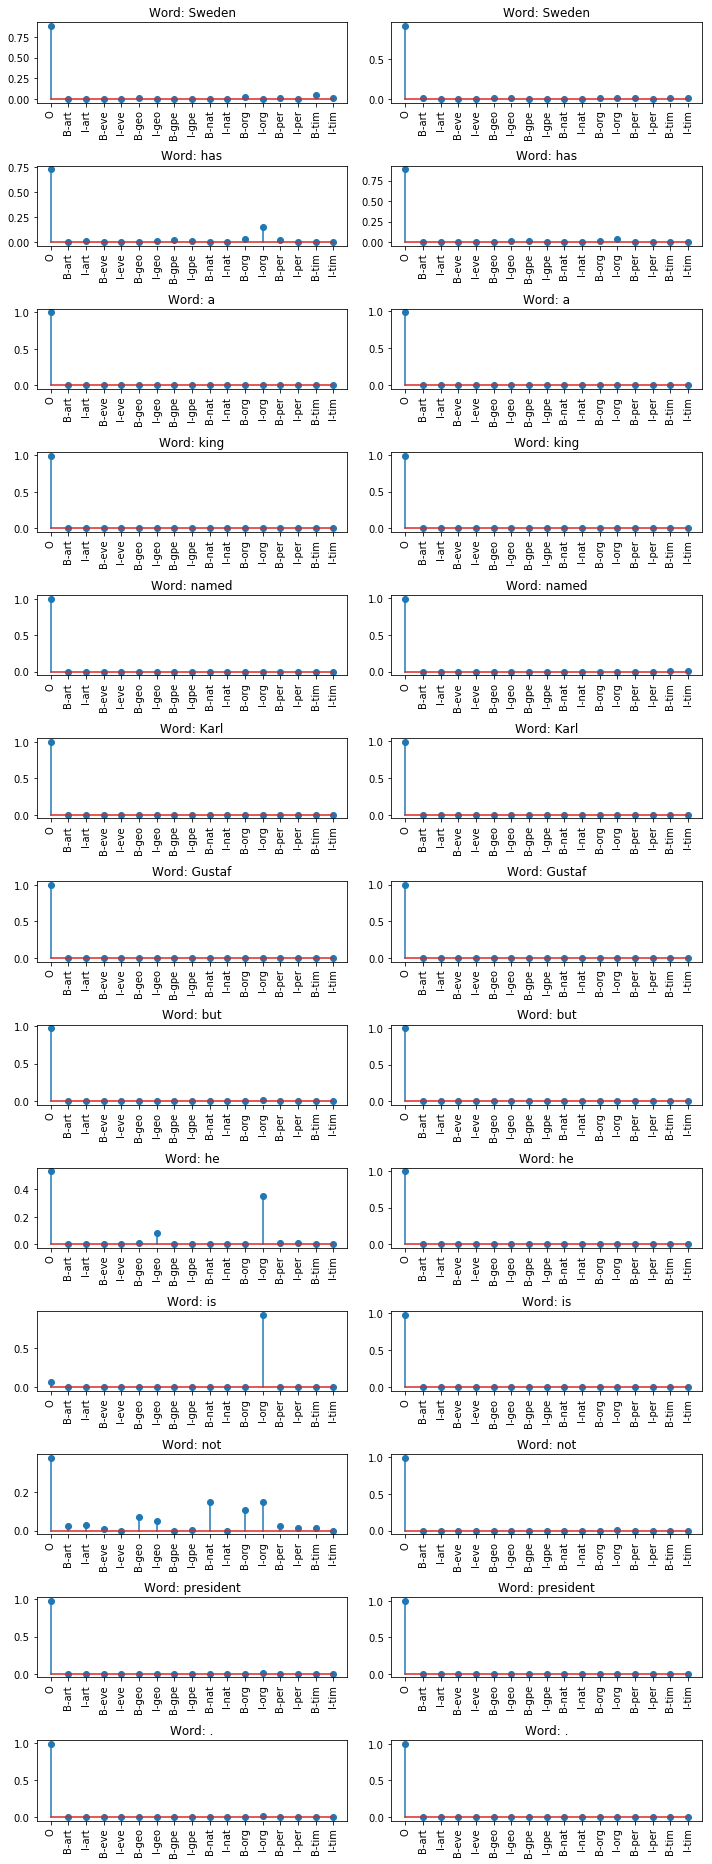

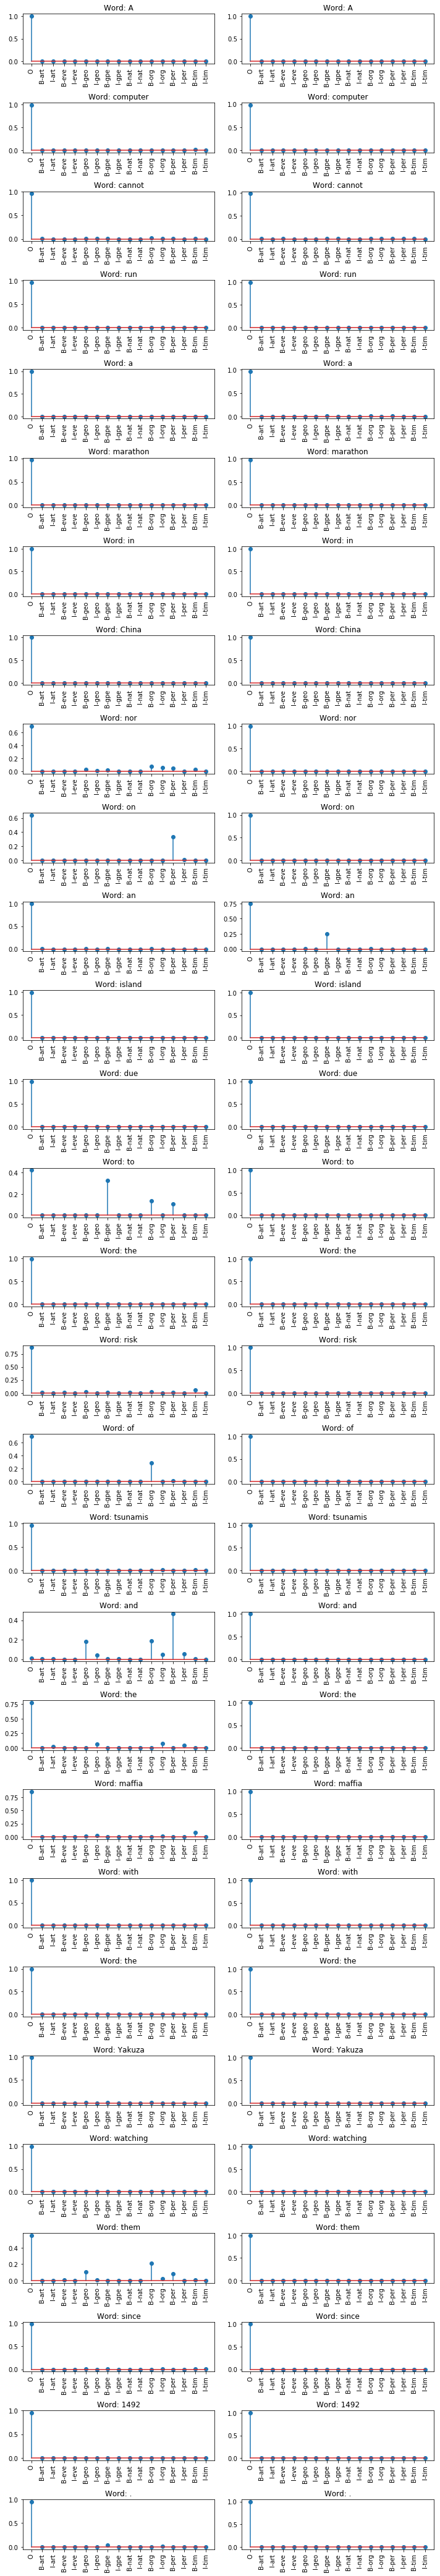

In [35]:
# Come up with two sentences that contains (according to us) a lot of NER tags
test_sentence1 = "Sweden has a king named Karl Gustaf but he is not president ."
test_sentence2 = "A computer cannot run a marathon in China nor on an island due to the risk of tsunamis and the maffia with the Yakuza watching them since 1492 ."

# Perform tagging on all sentences
rnn_test_1 = perform_ner(test_sentence1, rnn_model)
lstm_test_1 = perform_ner(test_sentence1, lstm_model)
rnn_test_2 = perform_ner(test_sentence2, rnn_model)
lstm_test_2 = perform_ner(test_sentence2, lstm_model)

# Plot comparisions between the two models and the two sentences
plot_compare_predictions(test_sentence1, rnn_test_1, lstm_test_1, tags)
plot_compare_predictions(test_sentence2, rnn_test_2, lstm_test_2, tags)
decode_compare_prediction(rnn_test_1, lstm_test_1)
decode_compare_prediction(rnn_test_1, lstm_test_1)

## 6. Evaluate your best model

Which model performed best, the vanilla RNN or the one using LSTMs? How do you evaluate this?

**Your answer**: Looking at the sample sentences througout the tests, both models perform really bad. This is actually really interesting since the F-score achieved is so high. It might be the case that neither of the four sentences we have used are good "general" sentences and that they are all edge-cases for our models. It might also be the case that we have totally missunderstood something vital, and our models really are bad.

As was mentioned before, in earlier testing (using the same models) we achived lower test _scores_ than the ones above, but the plots showed more reasonable PMFs. We will see below, when we compare the best model (which according to the validation score is the LSTM) to the baseline, if we are way off.

Using the best model you obtained, evaluate its performance using the data from the test set.

In [37]:
evaluation_lstm = lstm_model.evaluate(x_test, y_test, verbose=1)

print("\nLSTM -> {}: {}, {}: {}".format(lstm_model.metrics_names[0], evaluation_lstm[0], lstm_model.metrics_names[1],evaluation_lstm[1]))


LSTM -> loss: 0.04445173917333397, fbeta_score: 0.9877043408691765


In order to contextualize the metrics you computed in the test set, it's helpful to have a baseline to compare to. Can you come up with a simple way to obtain a baseline performance for this problem? Explain.

**Your asnwer**: Since the dataset is so biased, a good starting point for a baseline would be to check how many No-Type-tags there are in total. If 90% of the words in the dataset are labeled as No-Type, and we get a precision of 90%, it could simply be the case that we predict "No-type" for all words (and our classifier is not that good at all).

Our approach is therefore to calculate the fraction of No-type-tags in the dataset and use that number as the "lower than this and it's better to skip deep learning all together"-line.

If you managed to solve the last question, implement it here.

In [39]:
def getNoTypeFraction(l):
    """Returns fraction of No-Type tags in the np.array l"""
    
    number_of_each_tag = np.sum(l[:,0],axis=0)
    number_of_no_types = number_of_each_tag[0]
    return number_of_no_types/sum(number_of_each_tag)

print("F-Score acquired: {}, baseline: {}".format(evaluation_lstm[1], getNoTypeFraction(y_test)))

F-Score acquired: 0.9877043408691765, baseline: 0.7110833072672297


Given your baseline performance, do you think your model performed well?

**Your answer**: It seems like ~71% of the words in the dataset is No-Type labeled. Our achieved F-score is ~99% and we conclude that our model performs well!

This is -- again -- so interesting given the plots and decoded predictions above. Unfortunately there are no more supervision hours to utilize, or we could have asked about this, but for now we must conclude that numbers speak louder than plots.